# Capstone Project: Predicting the need for hospital admittance using machine learning

By: Yash Nagpaul

*(Data Science Diploma Candidate, BrainStation)*

## Table of Contents:
1. <a href="#Introduction">Introduction</a>
2. <a href="#Part-1-—-EDA">Part 1 — EDA</a>
3. <a href="#Part-2-—-Data-Cleaning">Part 2 — Data Cleaning</a>
4. <a href="#Part-3-—-Modeling">Part 3 — Modeling</a>

---
### Introduction
The aim of this report is to predict whether or not a person needs to be admitted to the hospital. We have a dataset of over 560,000 unidentified patients. The dataset consists of 972 unqiue features.

---
### Part 1 — EDA

In [2]:
# import helper libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('./data/admit_data.csv')
df.head()

,Unnamed: 0,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
0,1,B,4.0,40.0,Male,Hispanic or Latino,White or Caucasian,English,None,Single,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,B,4.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,B,2.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,A,2.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,A,3.0,84.0,Female,Hispanic or Latino,Other,Other,Pentecostal,Widowed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


NOTES:
- There seems to be a duplicate index column
- We can do some low effort cleaning along the way during data exploration

In [4]:
# drop duplicate index column
df = df.drop(columns=['Unnamed: 0'])
df.head()

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
0,B,4.0,40.0,Male,Hispanic or Latino,White or Caucasian,English,None,Single,Full Time,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,B,4.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,B,2.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,2.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,3.0,84.0,Female,Hispanic or Latino,Other,Other,Pentecostal,Widowed,Retired,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# work with a 10% sample
df = df.groupby('disposition').sample(frac=0.1, random_state=1011)
df

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
552788,A,2.0,59.0,Female,Non-Hispanic,White or Caucasian,English,Catholic,Married,Disabled,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4910,A,2.0,32.0,Male,Non-Hispanic,Black or African American,English,Muslim,Married,Full Time,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27011,A,2.0,64.0,Male,Non-Hispanic,White or Caucasian,English,Catholic,Single,Disabled,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4363,B,3.0,69.0,Female,Non-Hispanic,White or Caucasian,English,Catholic,Single,Retired,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
338490,A,2.0,54.0,Male,Non-Hispanic,Other,Other,Other,Married,Retired,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131074,C,4.0,90.0,Female,Non-Hispanic,White or Caucasian,English,Catholic,Widowed,Retired,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
375644,C,3.0,74.0,Female,Non-Hispanic,White or Caucasian,English,Catholic,Married,Retired,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36796,A,3.0,86.0,Female,Non-Hispanic,White or Caucasian,English,Protestant,Single,Retired,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
292916,A,2.0,47.0,Male,Non-Hispanic,White or Caucasian,English,Catholic,Divorced,Not Employed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# reset index values since we're working with a random 10% sample
df.reset_index(drop=True, inplace=True)
df.head()

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
0,A,2.0,59.0,Female,Non-Hispanic,White or Caucasian,English,Catholic,Married,Disabled,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,2.0,32.0,Male,Non-Hispanic,Black or African American,English,Muslim,Married,Full Time,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,2.0,64.0,Male,Non-Hispanic,White or Caucasian,English,Catholic,Single,Disabled,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,B,3.0,69.0,Female,Non-Hispanic,White or Caucasian,English,Catholic,Single,Retired,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,2.0,54.0,Male,Non-Hispanic,Other,Other,Other,Married,Retired,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Check for duplicate rows
df.duplicated().sum()

0

In [8]:
# Only 2 rows are duplicates, we can drop the duplicates with confidence because:
# it's an extremely small proprtion of the data, and
# we have over 900 features, which makes it very likely that the duplicate row is not intentional
df.drop_duplicates(inplace=True)

In [9]:
# get a sense of which columns have null values and how many

columns_with_nulls = 0

for column in df.columns:
    if df[column].isna().sum() > 0:
        columns_with_nulls += 1
        
        dots = '.' * (40 - len(df[column].name))
        
        print(df[column].name, dots, df[column].isna().sum())
        
print('How many columns with missing values?', columns_with_nulls)

esi ..................................... 239
age ..................................... 1
race .................................... 3
arrivalmode ............................. 2179
absolutelymphocytecount_last ............ 34529
acetonebld_last ......................... 56013
alanineaminotransferase(alt)_last ....... 43480
albumin_last ............................ 44876
alkphos_last ............................ 43358
anc(absneutrophilcount)_last ............ 34295
aniongap_last ........................... 35115
aspartateaminotransferase(ast)_last ..... 43743
b-typenatriureticpeptide,pro(probnp)_last  55021
baseexcess(poc)_last .................... 51990
baseexcess,venous(poc)_last ............. 54535
basos_last .............................. 34299
basosabs_last ........................... 51340
benzodiazepinesscreen,urine,noconf._last  56049
bilirubindirect_last .................... 50515
bilirubintotal_last ..................... 43460
bun_last ................................ 34967
bu

#### OBSERVATIONS:
- The dataset has a high level of sparsity (many missing values)
- We will need to think of a strategy to deal with this before we start making any predictions

In [10]:
# How many non-numeric columns do we have?

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df.select_dtypes(exclude=numerics).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56049 entries, 0 to 56048
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   dep_name          56049 non-null  object
 1   gender            56049 non-null  object
 2   ethnicity         56049 non-null  object
 3   race              56046 non-null  object
 4   lang              56049 non-null  object
 5   religion          56049 non-null  object
 6   maritalstatus     56049 non-null  object
 7   employstatus      56049 non-null  object
 8   insurance_status  56049 non-null  object
 9   disposition       56049 non-null  object
 10  arrivalmode       53870 non-null  object
 11  arrivalmonth      56049 non-null  object
 12  arrivalday        56049 non-null  object
 13  arrivalhour_bin   56049 non-null  object
 14  previousdispo     56049 non-null  object
dtypes: object(15)
memory usage: 6.8+ MB


#### NOTES:
- A total of 15 non-numeric columns that either need to be converted to numeric somehow or dropped
---

### Part 2 — Data Cleaning
---
#### `disposition` column
- Convert the column values to binary
- `Admit` = 1
- `Discharge` = 0

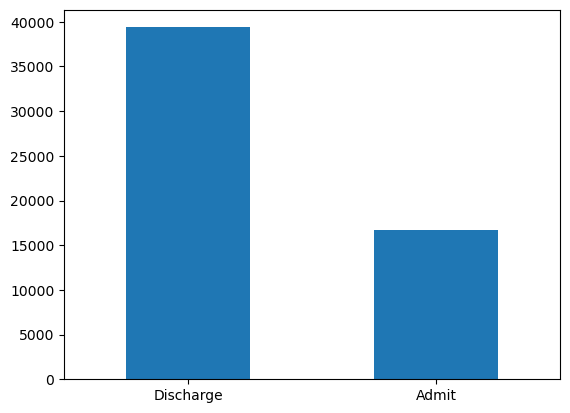

In [11]:
# first, visualize the distribution of classes in our target column

plt.figure()
df['disposition'].value_counts().plot(kind='bar', rot=0)
plt.show()

In [12]:
df['disposition'].value_counts(normalize=True)

Discharge    0.702689
Admit        0.297311
Name: disposition, dtype: float64

**Note**: Before splitting the dataset for model training, we will need to account for this imbalance between the classes in our target variable.

In [13]:
# Convert to binary

df.disposition = df.disposition.apply(lambda x: 1 if x == 'Admit' else 0)
df.disposition

0        1
1        1
2        1
3        1
4        1
        ..
56044    0
56045    0
56046    0
56047    0
56048    0
Name: disposition, Length: 56049, dtype: int64

#### NOTES:
- Doing this process many times will be tedious,
- For the remaining categorical columns, we will write a function that will convert all the categorical variables into dummy variables (one hot encoding)

In [14]:
# make sure none of those columns have an unusually large number of unique values

for column in df.select_dtypes(exclude=numerics).columns:
    print(df[column].value_counts(), '\n')

A    32280
B    16818
C     6951
Name: dep_name, dtype: int64 

Female    30980
Male      25069
Name: gender, dtype: int64 

Non-Hispanic          46264
Hispanic or Latino     9314
Unknown                 315
Patient Refused         156
Name: ethnicity, dtype: int64 

White or Caucasian                           29934
Black or African American                    15830
Other                                         8975
Asian                                          540
Patient Refused                                516
Unknown                                        159
American Indian or Alaska Native                49
Native Hawaiian or Other Pacific Islander       43
Name: race, dtype: int64 

English    51424
Other       4625
Name: lang, dtype: int64 

Catholic             18921
None                 13441
Christian             7553
Baptist               4080
Other                 2862
Pentecostal           2522
Protestant            2417
Jewish                1250
Muslim             

In [15]:
df.select_dtypes(exclude=numerics).columns

Index(['dep_name', 'gender', 'ethnicity', 'race', 'lang', 'religion',
       'maritalstatus', 'employstatus', 'insurance_status', 'arrivalmode',
       'arrivalmonth', 'arrivalday', 'arrivalhour_bin', 'previousdispo'],
      dtype='object')

In [16]:
for column_name in df.select_dtypes(exclude=numerics).columns:
    
    # creates sparse matrix by default
    encoder = OneHotEncoder()
    
    # make a dataframe from the column
    column_df = pd.DataFrame(df[column_name])
    
    # fit the OneHotEncoder to the column_df and transform the df
    encoded_column = encoder.fit_transform(column_df)
    
    # sparse -> dense
    dense_array = encoded_column.toarray() 
    
    # make a dataframe from the ENCODED column
    encoded_df = pd.DataFrame(dense_array, columns=encoder.get_feature_names_out([column_name]), dtype=int)
    
    # join this encoded_df with the main df
    df = pd.concat([df, encoded_df], axis=1)
    
    # drop the original column from the main df
    df = df.drop(column_name, axis=1)

df.head()

,esi,age,disposition,2ndarymalig,abdomhernia,abdomnlpain,abortcompl,acqfootdef,acrenlfail,acutecvd,...,previousdispo_AMA,previousdispo_Admit,previousdispo_Discharge,previousdispo_Eloped,previousdispo_LWBS after Triage,previousdispo_LWBS before Triage,previousdispo_No previous dispo,previousdispo_Observation,previousdispo_Send to L&D,previousdispo_Transfer to Another Facility
0,2.0,59.0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2.0,32.0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2.0,64.0,1,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,3.0,69.0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2.0,54.0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [17]:
print(f'Through one hot encoding the categorical variables, we have added {1070-972} new columns to our dataframe.')

Through one hot encoding the categorical variables, we have added 98 new columns to our dataframe.


- Now that all of our data is numerical, we are ready to think about making predictions, i.e., modelling
---
Part 3 — Modeling
---
- Before we start fitting any predictive models on our data, we should split the data that we have into 2 groups
- A large subset of the data can be used to train our models, and the remainder (i.e., the test set) can be used to see how the models perform on unseen data

In [18]:
# Split the dataset into training and test sets
df = df.reset_index()
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('disposition', axis=1),
    df['disposition'],
    test_size=0.2,
    stratify=df['disposition'],
    random_state=42
)

# sanity check
print('Training data shape:',X_train.shape)
print('Test data shape:',X_test.shape)

Training data shape: (44839, 1059)
Test data shape: (11210, 1059)


In [19]:
# TODO: #1 This would only make sense after the NaN / missing values have been dealt with
# df.corr().unstack().sort_values()

In [20]:
# TODO: #2 XGBoost before imputing
# why does XGBoost not need imputed data?

- We will use the **median** value of the columns with null values to impute the missing data.
- Given the sparsity of the dataset that we have, this is a reasonable approach. 
- The rationale is that many of these columns store continuous data
- This means that if we take another approach such as making dummy variables from the continious data, our model will we will be depriving our models of the information that can be obtained from the ordinality in these continious variables.
- There are other approaches of imputation as well such as using KNNs or Random Forests, but these approaches also rely on finding patterns in the data to estimate missing values, hence they are unlikely to be accurate because of the sparsity of this dataset.

In [21]:
# Use SimpleImputer from SKLearn

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='median')

# fit and transform the training data
X_train = imputer.fit_transform(X_train)

# only transform the test data
X_test = imputer.transform(X_test)

# sanity check
np.isnan(X_train).sum()

0

#### 3.1 Logistic Regression
- Let's begin with one of the simplest classification models: A Logistic Regression.
    - Briefly described, a logistic regression fits a logistic function on the input variables and outputs the probability of a binary target variable.
- We will use StatsModel to run a linear regression since it gives us statistical details such as p-value of any statistics we might be interested in.
- Then, we can filter out the insignificant variables before fitting other sophisticated machine learning models on our data? There's PCA for that tho
- Here I have opted for the StatsModels library due to the statistical details it provides along with the output (but we are interested more in the predictive modelling rather than p-values, for example)
- So, actually let's go with SKLearn

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

train_acc = logreg.score(X_train, y_train)
test_acc = accuracy_score(y_test, y_pred)

print('Model accuracy with training data:', round(train_acc*100,2),"%")
print('Model accuracy with test data:', round(test_acc*100,2),"%")

Model accuracy with training data: 99.85 %
Model accuracy with test data: 99.79 %


/Users/yashnagpaul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
# EXPERIMENT
log_probs = lr

NameError: name 'lr' is not defined

In [ ]:
# scale when necessary

# scaler = StandardScaler
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)